<a href="https://colab.research.google.com/github/podyssea/RecommenderSystems/blob/main/RecSys_coursework_2021_2210049p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessed Coursework Template Notebook

This is the template notebook for the RecSys(H) 2021 coursework. It deals with data preparation and evaluation only.

Please note:
 - use H1 text headings for grouping together blocks of cells. You can then hide these while working on other blocks
 - leave the cell output visible when you submit the notebook



## Setup block

Setup the data files, Python etc.

In [4]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  5594k      0  0:00:01  0:00:01 --:--:-- 5598k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  2606k      0 --:--:-- --:--:-- --:--:-- 2603k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  4252k      0  0:00:01  0:00:01 --:--:-- 4249k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0  2087k      0 --:--:-- --:--:-- --:--:-- 2085k


In [5]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions
SEED=42

# data preparation

In [6]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

In [7]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")
ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")


#stringify the id columns
def str_col(df):
  if "user_id" in df.columns:
    df["user_id"] = "u" + df.user_id.astype(str)
  if "book_id" in df.columns:
    df["book_id"] = "b" + df.book_id.astype(str)

str_col(books_df)
str_col(ratings_df)
str_col(to_read_df)
str_col(test)



# Implicit

In [8]:
to_read_df

,Unnamed: 0,user_id,book_id
0,386014,u1333,b1797
1,36194,u765,b1797
2,25568,u1042,b1797
3,596738,u1360,b1797
4,52814,u1782,b1797
...,...,...,...
135610,444981,u556,b1157
135611,428922,u343,b1157
135612,457472,u1193,b1743
135613,487831,u1121,b1743


#explicit

In [9]:
ratings_df

,Unnamed: 0,user_id,book_id,rating
0,0,u1,b258,5
1,130,u11,b258,3
2,1998,u143,b258,4
3,4731,u325,b258,4
4,5510,u362,b258,2
...,...,...,...,...
124757,438735,u1920,b1499,4
124758,439348,u334,b1499,2
124759,439505,u927,b1499,4
124760,439728,u1298,b1499,4


#test

In [10]:
test

,Unnamed: 0,user_id,book_id
0,26204,u978,b323
1,74616,u109,b323
2,334583,u1721,b323
3,297262,u429,b323
4,30956,u339,b323
...,...,...,...
33912,347299,u272,b1545
33913,1881,u126,b1333
33914,400826,u1841,b1513
33915,518727,u1599,b1513


#books

In [11]:
books_df

,Unnamed: 0,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,0,b1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,1,b2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,2,b3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,3,b4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,4,b5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,1989,b1990,11331421,11331421,6504537,83,1590514637,9.781591e+12,"Jan-Philipp Sendker, Kevin Wiliarty",2002.0,Das Herzenhören,The Art of Hearing Heartbeats,eng,3.98,41647,50338,5650,704,2697,10330,19670,16937,https://images.gr-assets.com/books/1320437247m...,https://images.gr-assets.com/books/1320437247s...
1822,1990,b1991,8935689,8935689,14366,50,1857231384,9.781857e+12,Iain M. Banks,1987.0,Consider Phlebas,"Consider Phlebas (Culture, #1)",eng,3.85,48649,53499,2666,1083,3656,12772,20533,15455,https://images.gr-assets.com/books/1327951890m...,https://images.gr-assets.com/books/1327951890s...
1823,1992,b1993,31332,31332,2925979,63,345434803,9.780345e+12,Anne Rice,1998.0,The Vampire Armand,"The Vampire Armand (The Vampire Chronicles, #6)",en-US,3.75,54919,57566,756,1129,4866,17158,18670,15743,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
1824,1996,b1997,9565548,9565548,14452295,33,054762834X,9.780548e+12,Robin LaFevers,2012.0,Grave Mercy,"Grave Mercy (His Fair Assassin, #1)",eng,3.92,70476,74683,7661,2257,4487,15591,27223,25125,https://images.gr-assets.com/books/1320269319m...,https://images.gr-assets.com/books/1320269319s...


In [12]:
books_df.sort_values('average_rating', ascending=False).head(5)

,Unnamed: 0,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
839,861,b862,17332218,17332218,16482835,34,765326361,9.780765e+12,Brandon Sanderson,2014.0,Words of Radiance,"Words of Radiance (The Stormlight Archive, #2)",eng,4.77,73572,108176,7261,154,404,2653,18272,86693,https://images.gr-assets.com/books/1391535251m...,https://images.gr-assets.com/books/1391535251s...
420,421,b422,862041,862041,2962492,76,545044251,9.780545e+12,J.K. Rowling,1998.0,Complete Harry Potter Boxed Set,"Harry Potter Boxset (Harry Potter, #1-7)",eng,4.74,190050,204125,6508,1105,1285,7020,30666,164049,https://images.gr-assets.com/books/1392579059m...,https://images.gr-assets.com/books/1392579059s...
1243,1307,b1308,17927395,17927395,25126749,39,NaN,NaN,Sarah J. Maas,2016.0,A Court of Mist and Fury,A Court of Mist and Fury (A Court of Thorns an...,eng,4.72,108384,126491,22700,931,1420,4725,18000,101415,https://images.gr-assets.com/books/1485259138m...,https://images.gr-assets.com/books/1485259138s...
974,1009,b1010,43070,43070,2244438,26,836218051,9.780836e+12,Bill Watterson,1988.0,The Essential Calvin and Hobbes: A Calvin and ...,The Essential Calvin and Hobbes: A Calvin and ...,en-US,4.65,93001,95543,598,717,895,5387,17566,70978,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
555,561,b562,7235533,7235533,8134945,48,765326353,9.780765e+12,Brandon Sanderson,2010.0,The Way of Kings,"The Way of Kings (The Stormlight Archive, #1)",eng,4.64,144822,164477,10947,1085,1827,7661,33962,119942,https://images.gr-assets.com/books/1388184640m...,https://images.gr-assets.com/books/1388184640s...


Here we construct the Interactions objects from `ratings.csv`, `to_read.csv` and `test.csv`. We manually specify the num_users and num_items parameters to all Interaction objects, in case the test set differs from your training sets.

In [13]:
from collections import defaultdict
from itertools import count, combinations

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)


rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)

test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)


uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.RandomState(SEED))
print(validation)

num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>
<Interactions dataset (1999 users x 1826 items x 27123 interactions)>


In [14]:
print(toread_dataset_train)

<Interactions dataset (1999 users x 1826 items x 108492 interactions)>


In [15]:
print(num_items)

1826


#Example code

To evaluate soem of your hand-implemented recommender systems (e.g. Q1, Q4), you will need to instantiate objects that match the specification of a Spotlight model, which `mrr_score()` expects.


Here is an example recommender object that returns 0 for each item, regardless of user.

In [16]:
from spotlight.evaluation import mrr_score, rmse_score


class dummymodel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )

#lets evaluate how the effeciveness of dummymodel

dummymodel(num_items)

# print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0



In [17]:

#note that the latest copy of Craig's Spotlight displays a progress bar if you set verbose=True
print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())


1999it [00:00, 2952.28it/s]

0.0


#Question 1

Non personalised baselines for ranking books based on statistics

In [18]:
average_rating = ratings_df[["book_id", "rating"]].groupby(["book_id"]).mean()
non_personalised_ar = average_rating['rating'].tolist()

class average_rating:
  
  def __init__(self, numitems):
    self.predictions=np.ones(numitems) * non_personalised_ar
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )


print(mrr_score(average_rating(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())

1999it [00:00, 2175.77it/s]

0.0370085786108787


In [19]:
number_of_ratings = books_df[["book_id", "ratings_count"]].groupby(["book_id"]).sum()
non_personalised_nor = number_of_ratings['ratings_count'].tolist()

class number_of_ratings:
  
  def __init__(self, numitems):
    self.predictions=np.ones(numitems) * non_personalised_nor
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )


print(mrr_score(number_of_ratings(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())

1999it [00:00, 2274.83it/s]

0.0458981602236436


In [20]:
star5_ratings = books_df['ratings_5'].tolist()
# star5_ratings

class number_of_5_star_ratings:
  
  def __init__(self, numitems):
    self.predictions=np.ones(numitems) * star5_ratings
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )
    

print(mrr_score(number_of_5_star_ratings(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())


1999it [00:00, 2248.80it/s]

0.09851435310152991


In [21]:
fractions_of_ratings = np.asarray(star5_ratings) / np.asarray(non_personalised_nor)

class fractions_of_5_star:
  
  def __init__(self, numitems):
    self.predictions=np.ones(numitems) * fractions_of_ratings
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )
    

print(mrr_score(fractions_of_5_star(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())

1999it [00:00, 2279.04it/s]

0.15971513656750713


# Question 2

In [22]:
#import necessary modules
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel
from collections import defaultdict
from itertools import count
import itertools
import time
from scipy.stats import rankdata

In [23]:
#divide the dataset
explicit_train, explicit_test = random_train_test_split(rating_dataset, random_state=np.random.RandomState(SEED))

In [24]:
#define the latent factors
latent_factors = [8,16,32,64]

In [25]:
for latent in latent_factors:
    print("\nstarting training for latent factor %d......)\n" % latent)
    emodel = ExplicitFactorizationModel(n_iter=5,
                                    embedding_dim=latent, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
    )

    emodel.fit(explicit_train)
    emodel.fit(explicit_test)

    print("======== MRR for latent factor %d" % latent)
    print("=====================================================)")
    print(mrr_score(emodel, test_dataset).mean())
    print("=====================================================)")



starting training for latent factor 8......)

======== MRR for latent factor 8
=====================================================)
0.01904702351175588
=====================================================)

starting training for latent factor 16......)

======== MRR for latent factor 16
=====================================================)
0.031209850957224644
=====================================================)

starting training for latent factor 32......)

======== MRR for latent factor 32
=====================================================)
0.04149793150543526
=====================================================)

starting training for latent factor 64......)

======== MRR for latent factor 64
=====================================================)
0.04534092443046921
=====================================================)


In [26]:
for latent in latent_factors:
  print("\nstarting training for latent factor %d......)\n" % latent)
  imodel = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
                                      embedding_dim=latent, #this is Spotlight default
                                      use_cuda=False,
                                      random_state=np.random.RandomState(SEED) # ensure results are repeatable
  )

  imodel.fit(explicit_train)
  imodel.fit(explicit_test)

  print("======== MRR ========= for latent factor %d" % latent)
  print("=====================================================)")
  print(mrr_score(imodel, test_dataset).mean())
  print("=====================================================)")


starting training for latent factor 8......)

======== MRR ========= for latent factor 8
=====================================================)
0.23233918546574875
=====================================================)

starting training for latent factor 16......)

======== MRR ========= for latent factor 16
=====================================================)
0.22353637136028331
=====================================================)

starting training for latent factor 32......)

======== MRR ========= for latent factor 32
=====================================================)
0.22433240429738677
=====================================================)

starting training for latent factor 64......)

======== MRR ========= for latent factor 64
=====================================================)
0.20716171577852419
=====================================================)


In [27]:
print("Best Model is Implicit with latent factor 8")

Best Model is Implicit with latent factor 8


# Question 3 (a)

In [28]:
for latent in latent_factors:

  print("\nstarting training for latent factor %d......)\n" % latent)
  implicit_model = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
                                              embedding_dim=latent, 
                                              use_cuda=False, 
                                              random_state=np.random.RandomState(SEED))
  
  implicit_model.fit(toread_dataset_train, verbose=False)
  implicit_model.fit(validation)

  print("======== MRR ========= for latent factor %d" % latent)
  print("=====================================================)")
  print(mrr_score(implicit_model, test_dataset).mean())
  print("=====================================================)")


starting training for latent factor 8......)

======== MRR ========= for latent factor 8
=====================================================)
0.22416803639915198
=====================================================)

starting training for latent factor 16......)

======== MRR ========= for latent factor 16
=====================================================)
0.2281702359116066
=====================================================)

starting training for latent factor 32......)

======== MRR ========= for latent factor 32
=====================================================)
0.2278224429675155
=====================================================)

starting training for latent factor 64......)

======== MRR ========= for latent factor 64
=====================================================)
0.1951235538404123
=====================================================)


In [29]:
print("Best Model is Implicit with latent factor 16")

Best Model is Implicit with latent factor 16


# Question 3 (b)

In [30]:
books_df_replicate = books_df.copy()
books_df_replicate.rename(columns = {"Unnamed: 0" : "item_id"}, inplace = True)


In [31]:
def item_to_titles(item_ids):
  return books_df_replicate.loc[books_df_replicate["item_id"].isin(item_ids)]["title"]

def find_common_titles(a,b, predictions):

  previously_vs_predicted = item_to_titles(np.intersect1d(a, predictions))
  print("These titles were predicted to be previously shelved correctly")
  print(previously_vs_predicted)

  currently_vs_predicted = item_to_titles(np.intersect1d(b, predictions))
  print("\n\nThese titles were predicted to be currently shelved correctly")
  print(currently_vs_predicted)
  
def get_predictions_for_highest_rated_user(user_id):
  item_ids_indexes_prev = np.where(toread_dataset.user_ids == user_id)
  previously_shelved = toread_dataset.item_ids[item_ids_indexes_prev]

  item_ids_indexes_curr = np.where(test_dataset.user_ids == user_id)
  currently_shelved = test_dataset.item_ids[item_ids_indexes_curr]

  predictions = implicit_model.predict(user_id)
  predicted_shelved = np.where(predictions > 0)[0]

  shelved_items = [previously_shelved, currently_shelved, predicted_shelved]

  return find_common_titles(previously_shelved, currently_shelved, predicted_shelved)

#Train the best model in terms of MRR
best_implicit_model = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
                                            embedding_dim=16, 
                                            use_cuda=False, 
                                            random_state=np.random.RandomState(SEED))

best_implicit_model.fit(toread_dataset_train, verbose=False)
best_implicit_model.fit(validation)

In [32]:
results = {}
combos = list(combinations(range(3), 2))
shelved = ["previously","currently","predicted"]

mrr_scores = mrr_score(implicit_model, test_dataset)
# user_id = test_dataset.user_ids[mrr_scores.argmax()]

m = max(mrr_scores)
indexes_of_highest = [i for i, j in enumerate(mrr_scores) if j == m]
uids = test_dataset.user_ids[indexes_of_highest]

index_to_user_id = []
for uid in uids:
  user_id_convert = uid_rev_map.get(uid)
  index_to_user_id.append(user_id_convert)

print("To 5 highest rated users are: ", index_to_user_id[:5], "with uids ", uids[:5])

To 5 highest rated users are:  ['u912', 'u1491', 'u1479', 'u240', 'u1468'] with uids  [ 24  25  75  83 101]


In [33]:
for uid in uids[:5]:
  print("Results for", uid_rev_map.get(uid))
  get_predictions_for_highest_rated_user(uid)
  print("============================================================\n\n\n")

Results for u912
These titles were predicted to be previously shelved correctly
7                                  The Catcher in the Rye
9                                     Pride and Prejudice
16                   Catching Fire (The Hunger Games, #2)
21                                       The Lovely Bones
33                Fifty Shades of Grey (Fifty Shades, #1)
                              ...                        
896                                   Luckiest Girl Alive
1009    The Perfect Storm: A True Story of Men Against...
1030    SuperFreakonomics: Global Cooling, Patriotic P...
1282                  The Blind Side: Evolution of a Game
1492                  Deadlocked (Sookie Stackhouse, #12)
Name: title, Length: 75, dtype: object


These titles were predicted to be currently shelved correctly
3                                  To Kill a Mockingbird
10                                       The Kite Runner
15      The Girl with the Dragon Tattoo (Millennium, #1)
23     H

# Question 3c

In [34]:
books_df_sorted = books_df.sort_values('average_rating', ascending=False)
books_df_sorted[:5]

,Unnamed: 0,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
839,861,b862,17332218,17332218,16482835,34,765326361,9.780765e+12,Brandon Sanderson,2014.0,Words of Radiance,"Words of Radiance (The Stormlight Archive, #2)",eng,4.77,73572,108176,7261,154,404,2653,18272,86693,https://images.gr-assets.com/books/1391535251m...,https://images.gr-assets.com/books/1391535251s...
420,421,b422,862041,862041,2962492,76,545044251,9.780545e+12,J.K. Rowling,1998.0,Complete Harry Potter Boxed Set,"Harry Potter Boxset (Harry Potter, #1-7)",eng,4.74,190050,204125,6508,1105,1285,7020,30666,164049,https://images.gr-assets.com/books/1392579059m...,https://images.gr-assets.com/books/1392579059s...
1243,1307,b1308,17927395,17927395,25126749,39,NaN,NaN,Sarah J. Maas,2016.0,A Court of Mist and Fury,A Court of Mist and Fury (A Court of Thorns an...,eng,4.72,108384,126491,22700,931,1420,4725,18000,101415,https://images.gr-assets.com/books/1485259138m...,https://images.gr-assets.com/books/1485259138s...
974,1009,b1010,43070,43070,2244438,26,836218051,9.780836e+12,Bill Watterson,1988.0,The Essential Calvin and Hobbes: A Calvin and ...,The Essential Calvin and Hobbes: A Calvin and ...,en-US,4.65,93001,95543,598,717,895,5387,17566,70978,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
555,561,b562,7235533,7235533,8134945,48,765326353,9.780765e+12,Brandon Sanderson,2010.0,The Way of Kings,"The Way of Kings (The Stormlight Archive, #1)",eng,4.64,144822,164477,10947,1085,1827,7661,33962,119942,https://images.gr-assets.com/books/1388184640m...,https://images.gr-assets.com/books/1388184640s...


In [35]:
top_5 = books_df_sorted[['average_rating', 'book_id']][:5]
top_5_bookids = top_5['book_id'].tolist()
top_5_itemids = []
for itemid in top_5_bookids:
  print(iid_map.get(itemid))
  top_5_itemids.append(iid_map.get(itemid))

top_5_itemids

1726
1181
1808
884
1425


[1726, 1181, 1808, 884, 1425]

In [36]:
top_5_embeddings = implicit_model._net.item_embeddings.weight[top_5_itemids]
top_5_embeddings

tensor([[ 3.9215e-01,  6.2611e-01,  1.0020e+00,  3.6695e-01, -7.8785e-02,
          4.8278e-01, -4.8430e-01, -8.3853e-01, -8.6347e-01, -3.4951e-01,
         -8.9406e-01,  1.2325e+00, -4.5236e-01,  3.5929e-01, -6.5597e-01,
          2.4485e+00, -4.9889e-01,  9.2668e-01, -1.6462e-01, -1.5614e+00,
          6.6127e-01, -4.6087e-01, -8.7617e-01,  7.9003e-01,  2.2882e-01,
          2.5179e-01,  6.9075e-01, -4.5294e-01, -3.1196e-01,  9.0759e-01,
         -7.0460e-01, -9.0421e-01,  7.7693e-01, -6.8810e-01, -1.3167e+00,
          7.3482e-01,  1.8754e+00,  5.6747e-01,  1.4036e-01, -3.7531e-01,
         -1.1994e-01, -4.1962e-01, -1.1896e+00,  2.2634e-01, -8.5787e-01,
          3.1113e-01,  4.9792e-01,  7.6137e-02, -2.3772e-01, -2.6628e-01,
          7.7050e-01, -7.7995e-01, -4.3699e-01, -4.7693e-01,  1.2760e+00,
          2.2708e-01, -2.7411e-01, -6.2900e-01, -3.3540e-01, -4.0469e-02,
          1.5615e+00,  7.5470e-01, -5.4718e-01, -1.2403e+00],
        [-5.8638e-01,  8.6708e-01,  6.6817e-01,  4

In [37]:
from scipy import spatial
similarities = []

for combo in combinations(range(5),2):
  i = top_5_embeddings[combo[0]].detach().numpy()
  j = top_5_embeddings[combo[1]].detach().numpy()
  similarities.append(1-spatial.distance.cosine(i,j))

intra_list_div = 2/(5*4) * sum(similarities)
print(intra_list_div)

0.2069293983280659


#Question 4

In [38]:
class combsumIF:  
  def __init__(self):
    self.explicit = self.create_train_model(rating_dataset)
    self.implicit = self.create_train_model(toread_dataset_train)
 
  def create_train_model(self,dataset):
    model = ImplicitFactorizationModel(n_iter = 5, loss = "bpr", random_state=np.random.RandomState(SEED), embedding_dim = 16)
    model.fit(dataset)
    model.fit(validation)
    return model
 
  def predict(self, uid):
    # returns the combined rating
    return 0.5* self.explicit.predict(uid) + 0.5 * self.implicit.predict(uid)

In [39]:
q4 = combsumIF()

In [40]:
q4_mrr_scores = mrr_score(q4, test_dataset)

In [41]:
print(q4_mrr_scores)

[0.   0.25 0.25 ... 0.   0.   0.  ]


In [42]:
#best model from q2
best_implicit_q2 = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
                                    embedding_dim=8, #this is Spotlight default
                                    use_cuda=False,
                                    random_state=np.random.RandomState(SEED) # ensure results are repeatable
)

best_implicit_q2.fit(explicit_train)
best_implicit_q2.fit(explicit_test)

q2_mrr_scores = mrr_score(best_implicit_q2, test_dataset)
print("======== MRR ========= for latent factor 8")
print("=====================================================)")
print(mrr_score(best_implicit_q2, test_dataset).mean())
print("=====================================================)")

======== MRR ========= for latent factor 8
=====================================================)
0.23233918546574875
=====================================================)


In [43]:
#best model from q3
best_implicit_q3 = ImplicitFactorizationModel(loss="bpr",n_iter=5, 
                                            embedding_dim=16, 
                                            use_cuda=False, 
                                            random_state=np.random.RandomState(SEED))

best_implicit_q3.fit(toread_dataset_train, verbose=False)
best_implicit_q3.fit(validation)


q3_mrr_scores = mrr_score(best_implicit_q3, test_dataset)
print("======== MRR ========= for latent factor 16")
print("=====================================================)")
print(mrr_score(best_implicit_q3, test_dataset).mean())
print("=====================================================)")

======== MRR ========= for latent factor 16
=====================================================)
0.2281702359116066
=====================================================)


In [44]:
import matplotlib.pyplot as plt

#graphs
diff_q2_q4 = q4_mrr_scores - q2_mrr_scores # <------best
diff_q3_q4 = q4_mrr_scores - q3_mrr_scores

print("\n=========== FROM Q2 ==========")
print(sum(i > 0 for i in diff_q2_q4), "are better")
print(sum(i < 0 for i in diff_q2_q4), "are worse")
print(sum(i == 0 for i in diff_q2_q4), "have not changed")

print("\n=========== FROM Q3 ==========")
print(sum(i > 0 for i in diff_q3_q4), "are better")
print(sum(i < 0 for i in diff_q3_q4), "are worse")
print(sum(i == 0 for i in diff_q3_q4), "have not changed")


=========== FROM Q2 ==========
669 are better
656 are worse
674 have not changed

=========== FROM Q3 ==========
601 are better
507 are worse
891 have not changed


In [45]:
data = {'item_ids' : uid_map.keys(), 'Previous RR': q2_mrr_scores, 'New RR': q4_mrr_scores}  
RR_df = pd.DataFrame(data) 
RR_df["diff"] = RR_df['New RR'] - RR_df['Previous RR']
RR_df = RR_df[RR_df['diff'] != 0]
RR_df

,item_ids,Previous RR,New RR,diff
1,u109,0.000000,0.250000,0.250000
2,u1721,0.142857,0.250000,0.107143
3,u429,0.125000,0.333333,0.208333
4,u339,1.000000,0.166667,-0.833333
5,u302,0.000000,0.142857,0.142857
...,...,...,...,...
1981,u965,0.100000,0.000000,-0.100000
1984,u1272,0.125000,0.333333,0.208333
1986,u120,0.000000,0.333333,0.333333
1993,u1142,0.000000,1.000000,1.000000


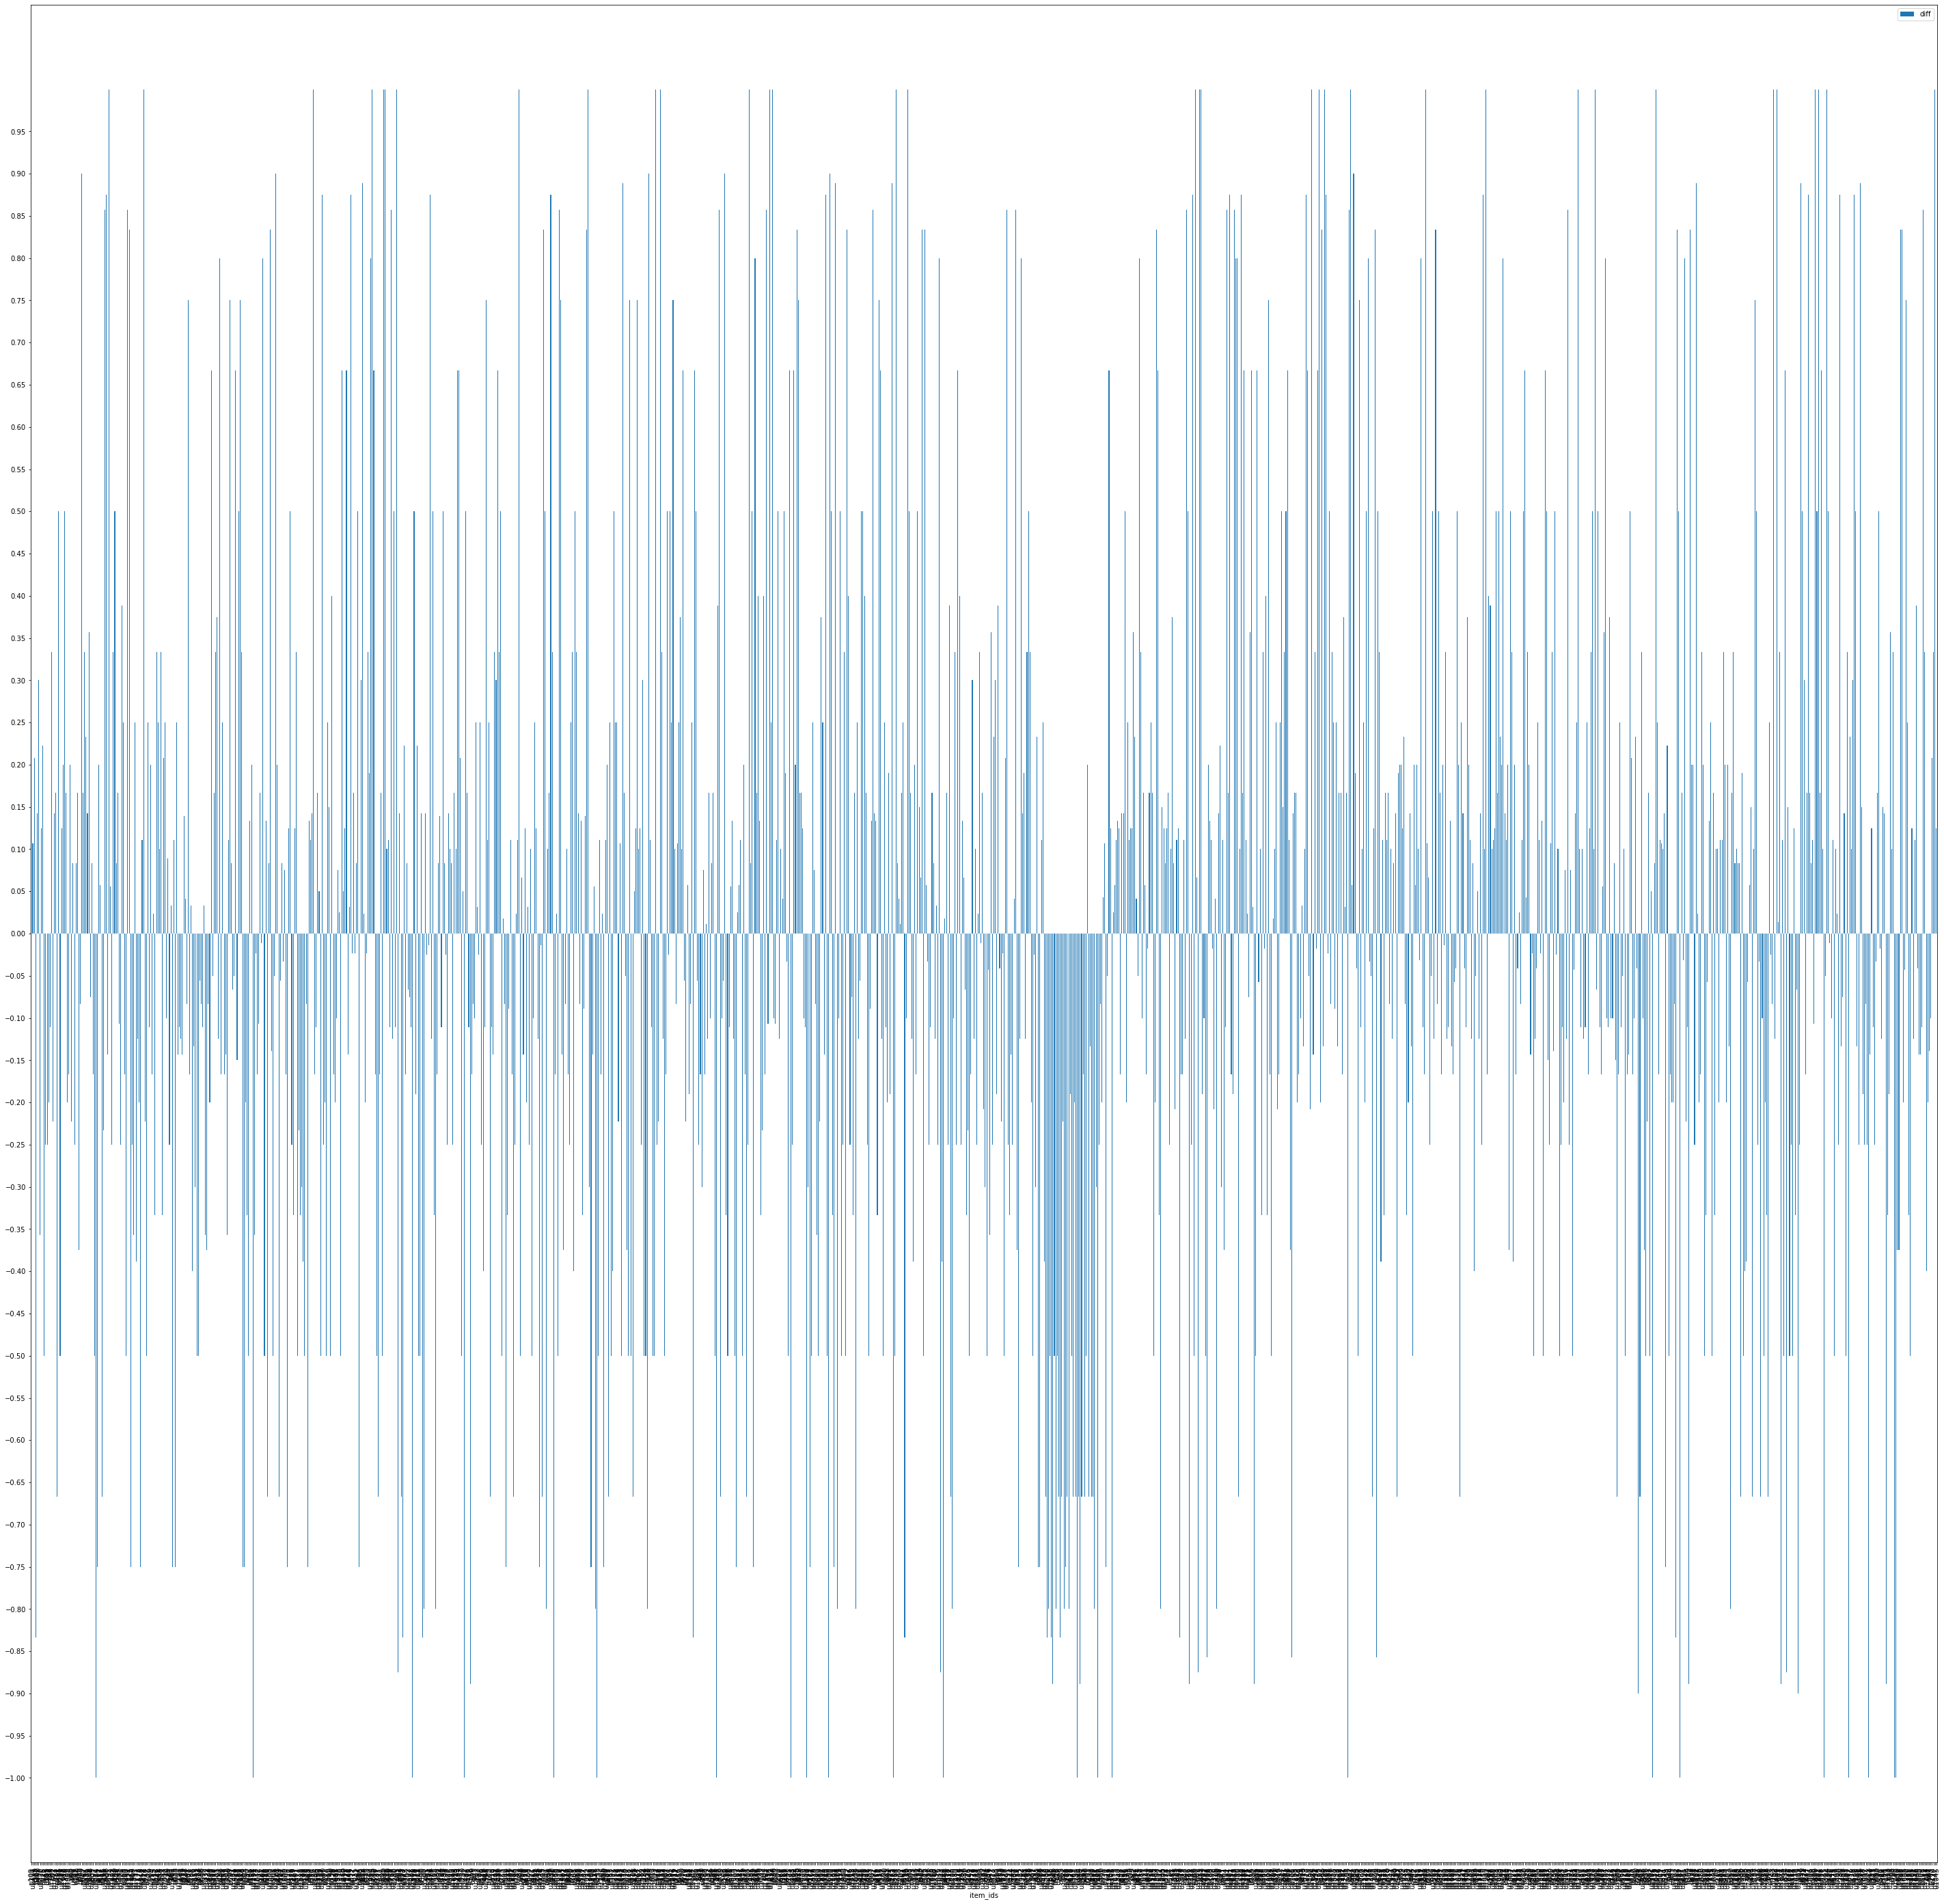

In [46]:
RR_df.plot(x ='item_ids', y='diff', kind = 'bar', figsize=(50,50))
y_ticks = np.arange(-1, 1, 0.05)
plt.yticks(y_ticks)
plt.xticks(rotation=90)
plt.show()

# Question 5

In [47]:
## Adapated from RecSys - Lab 1 Solution
def calculate_lift():
  positives=ratings_df[ratings_df["rating"]>=4]
  positives

  # #join positives with itself on userId to get all pairs of books watched by a given user.

  pairs=pd.merge(positives, positives, on=["user_id"])
  pairs

  # #we only want A->B, not B->A. Use the timestamps to restrict the selected pairs
  sequences=pairs[pairs['Unnamed: 0_x'] < pairs['Unnamed: 0_y']] 
  sequences

  # #lets count the frequency of each pair of books
  paircounts=sequences[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x", "book_id_y"]).count()
  paircounts

  # paircounts
  #sort by the most popular pairs.
  pairswithcounts_reset = paircounts.reset_index()
  pairswithcounts = pairswithcounts_reset.rename(columns={'user_id' : 'count'}).sort_values(['count'], ascending=False)
  pairswithcounts.head()

  pairswithcounts.merge(books_df, left_on=["book_id_x"], right_on="book_id").merge(books_df, left_on=["book_id_y"], right_on="book_id")[["title_x", "title_y"]]

  # # pairswithcounts gives is the frequency of (X AND Y). 

  # #We therefore need the counts of movies
  bookCounts = positives.groupby(['book_id']).count()[['user_id']].reset_index().rename(columns={'user_id' : 'count'})
  bookCounts

  # #lets puts all the information in the sample dataframe.
  allstats = pairswithcounts.merge(bookCounts, left_on='book_id_x', right_on='book_id').merge(bookCounts, left_on='book_id_y', right_on='book_id')
  allstats

  # #and drop out some unused columns
  allstats = allstats[['book_id_x', 'book_id_y', 'count', 'count_x', 'count_y']]
  allstats

  allstats = allstats.loc[:,~allstats.columns.duplicated()]
  allstats

  # #to calculate probabilites we need a denominator. I used the number of total ratings
  num=float(ratings_df.count()["rating"])

  # #we can then perform artihmetic on columns
  allstats["lift"] = (allstats["count"] / num ) / ( (allstats["count_x"] / num) * (allstats["count_y"] / num))
  allstats["loglift"] = np.log(allstats["lift"])

  withtitles = allstats.merge(books_df, left_on=['book_id_x'],  right_on="book_id").merge(books_df, left_on=["book_id_y"], right_on="book_id")
  # withtitles = withtitles.sort_values(['lift'], ascending=False)
  withtitles


  withtitles["support"] = withtitles["count"] / sequences["book_id_x"].count()
  withtitles[["title_x", "book_id_x", "book_id_y", "lift", "support"]]
  final = withtitles[["title_y", "title_x", "book_id_x", "book_id_y", "lift", "support", "count", "loglift"]]
  final = final.loc[:,~final.columns.duplicated()]
  return final

In [48]:
calculate_lift()

,title_y,title_x,book_id_x,book_id_y,lift,support,count,loglift
0,"Catching Fire (The Hunger Games, #2)","The Hunger Games (The Hunger Games, #1)",b1,b17,364.310869,1.999159e-04,365,5.898008
1,"Catching Fire (The Hunger Games, #2)",Harry Potter and the Sorcerer's Stone (Harry P...,b2,b17,1678.391936,1.999159e-04,365,7.425591
2,"Catching Fire (The Hunger Games, #2)",Harry Potter and the Goblet of Fire (Harry Pot...,b24,b17,1912.241959,1.999159e-04,365,7.556032
3,"Catching Fire (The Hunger Games, #2)",Harry Potter and the Half-Blood Prince (Harry ...,b27,b17,1474.298433,1.999159e-04,365,7.295938
4,"Catching Fire (The Hunger Games, #2)",Harry Potter and the Prisoner of Azkaban (Harr...,b18,b17,1527.715043,1.999159e-04,365,7.331528
...,...,...,...,...,...,...,...,...
721164,"Piercing the Darkness (Darkness, #2)",Nights in Rodanthe,b622,b1925,17823.142857,5.477147e-07,1,9.788253
721165,"Piercing the Darkness (Darkness, #2)","This Present Darkness (Darkness, #1)",b1218,b1925,17823.142857,5.477147e-07,1,9.788253
721166,"Piercing the Darkness (Darkness, #2)","At First Sight (Jeremy Marsh & Lexie Darnell, #2)",b1459,b1925,20793.666667,5.477147e-07,1,9.942404
721167,"Gone (Gone, #1)",The Absolutely True Diary of a Part-Time Indian,b591,b685,1919.415385,5.477147e-07,1,7.559776


In [49]:
class loglift:
  def __init__(self, min_sup = 0):
    self.minimum_support = min_sup
    self.df = lifts.loc[(lifts["support"] > self.minimum_support)]
    self.book_ids = books_df["book_id"].values
    self.book_lift_scores = self.calculate_book_lift_scores()
 
  def calculate_book_lift_scores(self): 
    return np.array([self.df.loc[(self.df["book_id_x"] == bid) | (self.df["book_id_y"] == bid)]["loglift"].values.sum() for bid in self.book_ids])
 
  def predict(self, uid):
    user_id = uid_rev_map[uid]
    scores = []
    scores = np.zeros(1826)
 
    already_rated_books = ratings_df.loc[ratings_df["user_id"] == user_id]["book_id"].values
    lift_indices = np.array([i for i  in range(len(self.book_ids)) if self.book_ids[i] not in already_rated_books])\
 
    scores[lift_indices] = self.book_lift_scores[lift_indices]
    return scores

In [50]:
lifts = calculate_lift()

In [51]:
q5_mrr_scores =  []

min_supports = np.linspace(lifts["support"].min(), lifts["support"].max(), 10)

for min_support in min_supports:
  q5_mrr_scores.append(mrr_score(loglift(min_support), validation))

In [52]:
print(q5_mrr_scores)

[array([0. , 0. , 0. , ..., 0. , 0. , 0.5]), array([0.  , 0.  , 0.25, ..., 0.  , 0.  , 0.25]), array([0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
       0.25      ]), array([0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
       0.25      ]), array([0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
       0.25      ]), array([0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.25]), array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.33333333]), array([0. , 0. , 0. , ..., 0. , 0. , 0.5]), array([0., 0., 0., ..., 0., 0., 0.]), array([0, 0, 0, ..., 0, 0, 0])]


In [53]:
mean_RR = []
for each in q5_mrr_scores:
  mean_RR.append(each.mean())

print(mean_RR)
print(min_supports)

[0.07603543835409768, 0.05580012228336391, 0.05725779556444889, 0.05790534155966872, 0.057036851759212935, 0.06443162057219086, 0.08278440094611339, 0.054070487624764754, 0.03266216441554111, 0.0]
[5.47714715e-07 3.26194541e-05 6.46911936e-05 9.67629330e-05
 1.28834672e-04 1.60906412e-04 1.92978151e-04 2.25049891e-04
 2.57121630e-04 2.89193370e-04]


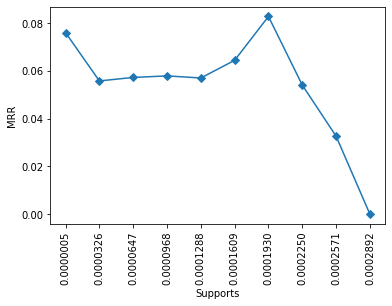

In [54]:
plt.plot(min_supports, mean_RR, marker = 'D')
plt.xticks(min_supports, rotation = 90)
plt.xlabel('Supports')
plt.ylabel('MRR')

best_min_support = min_supports[np.argmax(mean_RR)]

In [55]:
print(mrr_score(loglift(best_min_support), test_dataset).mean())

0.09883937505379806


# Question 6

In [60]:
## initiliase and train recommenders once
class initiliase_recommenders:
  def __init__(self):
    ## lowest performing models
    self.average_rating = average_rating(num_items)
    self.number_of_ratings = number_of_ratings(num_items)  
    self.emodel = ExplicitFactorizationModel(n_iter=5,random_state=np.random.RandomState(SEED))
 
    ## highest performing models
 
    ## avg MRR around 0.1 
    self.number_of_5_star_ratings = number_of_5_star_ratings(num_items)
    self.loglift = loglift(best_min_support)
    ## avg MRR around 0.15
    self.fractions_of_5_star = fractions_of_5_star(num_items)
    ## avg MRR > 0.2
    self.imodel = ImplicitFactorizationModel(n_iter = 5, loss = "bpr", random_state=np.random.RandomState(SEED))
    self.best_implicit_model = ImplicitFactorizationModel(n_iter = 5, loss = "bpr", random_state=np.random.RandomState(SEED), embedding_dim = 16)
 
    self.train_models()
 
    self.rec_list = self.iterate_over()
 
  def train_models(self):
    self.emodel.fit(rating_dataset)
    self.imodel.fit(rating_dataset)
    self.best_implicit_model.fit(toread_dataset_train)
 
  def iterate_over(self):
    recommenders = []
    for attr, value in self.__dict__.items():
          recommenders.append(value)
    return recommenders

In [61]:
class combine_recommenders:
  def __init__(self, recommenders, weights = []):
    self.recommenders = recommenders
    self.number_of_recommenders = len(recommenders)

    if len(weights) == self.number_of_recommenders:
      self.weights = weights
    else:
      self.weights = np.ones(self.number_of_recommenders) * 1/self.number_of_recommenders

  def predict(self, uid):
    predictions = 0
    for rec in range(self.number_of_recommenders):
      predictions += self.recommenders[rec].predict(uid) * self.weights[rec]
    return predictions

In [62]:
trained_recommenders = initiliase_recommenders()

In [63]:
def calculate_bias_weight(bias,indexes):
  weights = np.ones(8) * (1-bias*len(indexes))/(8-len(indexes))
  for i in indexes:
    weights[i] = bias
  return weights

#Get Weights

In [65]:
no_of_recommenders = 8
weights_list_without_bias = []
recommender_indices = list(range(no_of_recommenders))
weights_list_without_bias.append(np.ones(no_of_recommenders) * 1/no_of_recommenders)

In [66]:
bias_test = 0.3
weights_list_with_point3_bias = []
for i in range(no_of_recommenders):
  weights_list_with_point3_bias.append(calculate_bias_weight(bias_test, [i]))

In [67]:
highest_group_equal_weights = []
for bias in [0.15, 0.17]:
  highest_group_equal_weights.append(calculate_bias_weight(bias, recommender_indices[3:]))

In [68]:
two_highest_rec_equal_weights = []
for bias in [0.2,0.3,0.4]:
  two_highest_rec_equal_weights.append(calculate_bias_weight(bias, recommender_indices[6:]))

#Get MRR Scores

In [131]:
q6_mrr_scores_without_bias = mrr_score(combine_recommenders(trained_recommenders.rec_list, weights_list_without_bias), validation).mean()

In [132]:
print(q6_mrr_scores_without_bias)

0.02878363785067137


[array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])]


In [118]:
q6_mmr_scores_with_point3_bias = []
for each in weights_list_with_point3_bias:
  q6_mmr_scores_with_point3_bias.append(mrr_score(combine_recommenders(trained_recommenders.rec_list, each), validation).mean())

In [120]:
print(q6_mmr_scores_with_point3_bias)

[0.02878363785067137, 0.028197233537403624, 0.02878363785067137, 0.055491039170378835, 0.02878363785067137, 0.02878363785067137, 0.02878363785067137, 0.02878363785067137]


In [84]:
q6_mmr_scores_highest_group_equal_weights = []
for each in highest_group_equal_weights:
  q6_mmr_scores_highest_group_equal_weights.append(mrr_score(combine_recommenders(trained_recommenders.rec_list, each), validation).mean())

In [110]:
print(q6_mmr_scores_highest_group_equal_weights)

[0.04191083637056623, 0.05952639017921659]


In [91]:
q6_mmr_scores_two_highest_rec_equal_weights = []
for each in two_highest_rec_equal_weights:
  q6_mmr_scores_two_highest_rec_equal_weights.append(mrr_score(combine_recommenders(trained_recommenders.rec_list, each), validation).mean())

In [92]:
print(q6_mmr_scores_two_highest_rec_equal_weights)

[0.02878363785067137, 0.02878363785067137, 0.02878363785067137]


In [172]:
flattened_list = []
flattened_list.append(q6_mrr_scores_without_bias)

for each in q6_mmr_scores_with_point3_bias:
  flattened_list.append(each)

for each in q6_mmr_scores_highest_group_equal_weights:
  flattened_list.append(each)

for each in q6_mmr_scores_two_highest_rec_equal_weights:
  flattened_list.append(each)

#Get Graph

Text(0.5, 1.0, 'MRR/Bias Experiment')

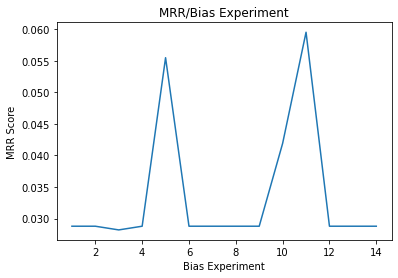

In [184]:
plt.plot(range(1,15), flattened_list)
plt.ylabel('MRR Score')
plt.xlabel('Bias Experiment')
plt.title('MRR/Bias Experiment')
